# Introduction

This exercise makes use of the database you created in `Exercise02` and the BEL statement parsers you write with regular expressions in `Reading_searching_sending.ipynb`.

In [1]:
import pandas as pd
import os, json, re, time
time.asctime()

'Thu Oct  6 10:09:56 2016'

In [2]:
base = os.path.join(os.environ['BUG_FREE_EUREKA_BASE'])
base

'C:\\Users\\Nazneen\\Documents\\GitHub\\bug-free-eureka'

# Task 1

This exercise is about loading the HGNC data to create a dictionary from HGNC symbols to set of enzyme ID's.

## 1.1 Load Data

Load json data from `/data/exercise02/hgnc_complete_set.json`.

In [3]:
data_path=os.path.join(base, 'data', 'exercise02', 'hgnc_complete_set.json')
with open(data_path) as f:
    hgnc_json=json.load(f)

## 1.2 Reorganize Data into `pd.DataFrame`

Identify the relevant subdictionaries in your `dictionary -> response -> docs`. Load them to a data frame, 
then create a new data frame with just the HGNC symbol and Enzyme ID

In [4]:
docs=hgnc_json['response']['docs']

df_hgnc= pd.DataFrame(docs)
df_hgnc.head(1)
list(df_hgnc.columns) #check the columns involved.. but remember we only want 2

['_version_',
 'alias_name',
 'alias_symbol',
 'bioparadigms_slc',
 'ccds_id',
 'cd',
 'cosmic',
 'date_approved_reserved',
 'date_modified',
 'date_name_changed',
 'date_symbol_changed',
 'ena',
 'ensembl_gene_id',
 'entrez_id',
 'enzyme_id',
 'gene_family',
 'gene_family_id',
 'hgnc_id',
 'homeodb',
 'horde_id',
 'imgt',
 'intermediate_filament_db',
 'iuphar',
 'kznf_gene_catalog',
 'lncrnadb',
 'location',
 'location_sortable',
 'locus_group',
 'locus_type',
 'lsdb',
 'mamit-trnadb',
 'merops',
 'mgd_id',
 'mirbase',
 'name',
 'omim_id',
 'orphanet',
 'prev_name',
 'prev_symbol',
 'pseudogene.org',
 'pubmed_id',
 'refseq_accession',
 'rgd_id',
 'snornabase',
 'status',
 'symbol',
 'ucsc_id',
 'uniprot_ids',
 'uuid',
 'vega_id']

In [5]:
df_hgnc[['symbol','enzyme_id']].head(50) #check out those columns
#not all proteins are enzymes so not all have enzyme_ids

,symbol,enzyme_id
0,A1BG,NaN
1,A1BG-AS1,NaN
2,A1CF,NaN
3,A2M,NaN
4,A2M-AS1,NaN
5,A2ML1,NaN
6,A2ML1-AS1,NaN
7,A2ML1-AS2,NaN
8,A2MP1,NaN
9,A3GALT2,NaN


## 1.3 Build dictionary for lookup

Iterate over this dataframe to build a dictionary that is `{hgnc symbol: set of enzyme id's}`. Call this dictionary `symbol2ec`

In [6]:
symbol2ec={}

df_hgnc_sliced=df_hgnc[['symbol','enzyme_id']]

In [7]:
for idx, symbol, enzyme_ids in df_hgnc_sliced.itertuples():
    if isinstance(enzyme_ids, list): #if enzyme_ids is a list
        symbol2ec[symbol]= enzyme_ids #also possible:cast to set to look up set membership quickly later
    else:
        symbol2ec[symbol]= []

In [8]:
'AKT1' in symbol2ec #same as 'AKT1 in symbol2ec.keys()'

True

# Task 2

This subexercise is about validating protein and kinase activity statements in BEL. Refer to last Thursday's work in `Reading_searching_sending.ipynb`.

## 2.1 Valid HGNC

Write a function, `valid_hgnc(hgnc_symbol, symbol2ec_instance)` that takes a name and the dictionary from Task 1.3 and returns whether this is a valid name

In [9]:
def valid_hgnc(hgnc_symbol, symbol2ec_instance):
    #print("valid hgnc: ")
    #print(hgnc_symbol in symbol2ec_instance)
    return hgnc_symbol in symbol2ec_instance
        

assert valid_hgnc('AKT1', symbol2ec)
assert not valid_hgnc('blah blah', symbol2ec)

valid_hgnc('hello', symbol2ec)

False

## 2.2 Valid Kinase Activity

Write a function, `valid_kinase(hgnc_symbol, symbol2ec_instance)` that takes a name and the dictionary from Task 1.3 and returns whether this protein has kinase activity. Hint: an enzyme code reference can be found [here](http://brenda-enzymes.org/ecexplorer.php?browser=1&f[nodes]=132&f[action]=open&f[change]=153)

In [10]:
def valid_kinase(hgnc_symbol, symbol2ec_instance):
    if not valid_hgnc(hgnc_symbol, symbol2ec_instance):
        return False
    
    for ec_id in symbol2ec_instance[hgnc_symbol]:
        if ec_id.startswith('2.7.'):
            #print("it is a kinase")
            return True
        
    #print("not a kinase")
    return False

assert valid_kinase('AKT1', symbol2ec)
assert not valid_kinase('HIST1H4H', symbol2ec) #had a NaN value but we made it have an empty list

In [11]:
pattern = "^([a-z])\(([A-Z]+):([a-zA-Z0-9]+)\)\s(-\||->)\s([a-z])\(([A-Z]+):([a-zA-Z0-9]+)\)$"


text="p(HGNC:BCL2) -| p(HGNC:CYCS)"
p=re.compile(pattern)
p.match(text).groups()

('p', 'HGNC', 'BCL2', '-|', 'p', 'HGNC', 'CYCS')

In [12]:
match_protein = re.compile('p\(HGNC:(?P<name>\w+)\)')
print(match_protein.match('p(HGNC:ABC)').groupdict())

match_kin = re.compile('kin\(p\(HGNC:(?P<name>\w+)\)\)')
match_kin.match('kin(p(HGNC:ABC))').groupdict()

{'name': 'ABC'}


{'name': 'ABC'}

## 2.3 Putting it all together

Write a function, `validate_bel_term(term, symbol2ec_instance)` that parses a BEL term about either a protein, or the kinase activity of a protein and validates it.

```python
def validate_bel_term(term, symbol2ec_instance):
    pass
```

### Examples

```python
>>> # check that the proteins have valid HGNC codes
>>> validate_bel_term('p(HGNC:APP)', symbol2ec)
True
>>> validate_bel_term('p(HGNC:ABCDEF)', symbol2ec)
False
>>> # check that kinase activity annotations are only on proteins that are
>>> # actually protein kinases (hint: check EC annotation)
>>> validate_bel_term('kin(p(HGNC:APP))', symbol2ec)
False
>>> validate_bel_term('kin(p(HGNC:AKT1))', symbol2ec)
True
```

In [13]:
def validate_bel_term(term, symbol2ec_instance):
    #get name from BEL term
    ##if only protein:
    if term.startswith('p'):
        match_protein = re.compile('p\(HGNC:(?P<name>\w+)\)')
        my_dict=match_protein.match(term).groupdict()
        
        name=my_dict['name']
        ###check if name is a valid hgnc name              
        return valid_hgnc(name,symbol2ec_instance)
    
    ##else if kinase, do:
    elif term.startswith('kin'):
        match_kin = re.compile('kin\(p\(HGNC:(?P<name>\w+)\)\)')
        my_dict=match_kin.match(term).groupdict()
        name=my_dict['name']
    
    ###for those with valid HGNC codes, check if valid kinase
        if valid_hgnc(name,symbol2ec_instance):
            return valid_kinase(name, symbol2ec_instance)
    
    ###if invalid HGNC code
        return False

In [14]:
assert validate_bel_term('p(HGNC:APP)', symbol2ec)
assert not validate_bel_term('p(HGNC:ABCDEF)', symbol2ec)
assert not validate_bel_term('kin(p(HGNC:APP))', symbol2ec)
assert validate_bel_term('kin(p(HGNC:AKT1))', symbol2ec)

# Task 3

This task is about manual curation of text. You will be guided through translating the following text into BEL statements as strings within a python list.

## Document Definitions

Recall citations are written with source, title, then identifier as follows:

```
SET Citation = {"PubMed", "Nat Cell Biol 2007 Mar 9(3) 316-23", "17277771"}
```

Use these annotations and these namespaces:

```
DEFINE NAMESPACE HGNC AS URL "http://resource.belframework.org/belframework/20131211/namespace/hgnc-human-genes.belns"

DEFINE ANNOTATION CellLocation as LIST {"cell nucleus", "cytoplasm", "endoplasmic reticulum"}
```


## Source Text

> The following statements are from the document "BEL Exercise" in edition 00001 of the PyBEL Journal.
> The kinase activity of PI3K causes the increased abundance of AKT serine/threonine kinase 1 and AKT serine/threonine kinase 2 in the cytoplasm, 
> but only the increased expression of AKT serine/threonine kinase 1 in the endoplasmic reticulum. 
> Additionally, the abundance of AKT serine/threonine kinase 1 and AKT serine/threonine kinase 2 were found to be positively correlated in the cell nuclei.
> AKT serine/threonine kinase 2 increases GSK3 Beta in all of the nuclei, cytoplasm, and ER.

In [15]:
def get_symbol(name_in):
    return list(df_hgnc[df_hgnc.name == name_in]['symbol'][0])

In [16]:
definition_statements = [
    'SET DOCUMENT name = "BEL Exercise"'
    'DEFINE NAMESPACE HGNC AS URL "http://resource.belframework.org/belframework/20131211/namespace/hgnc-human-genes.belns"',
    'DEFINE ANNOTATION CellLocation AS LIST {"cell nucleus", "cytoplasm", "endoplasmic reticulum"}',
]

In [17]:
your_statements = [
    'SET Citation = {"PyBEL Journal", "Bel Exercise", "00001"}', 
    'SET Evidence = "The following statements are from the document "BEL Exercise" in edition 00001 of the PyBEL Journal. The kinase activity of PI3K causes the increased abundance of AKT serine/threonine kinase 1 and AKT serine/threonine kinase 2 in the cytoplasm, but only the increased expression of AKT serine/threonine kinase 1 in the endoplasmic reticulum. Additionally, the abundance of AKT serine/threonine kinase 1 and AKT serine/threonine kinase 2 were found to be postively correlated in the cell nuclei. AKT serine/threonine kinase 2 increases GSK3 Beta in all of the nuclei, cytoplasm, and ER."',
    'SET CellLocation = "cytoplasm"',
    'kin(p(HGNC:PIK3CA)) -> p(HGNC:AKT1)',
    'kin(p(HGNC:PIK3CA)) -> p(HGNC:AKT2)',
    'UNSET CellLocation',
    'SET CellLocation = "endoplasmic reticulum"',
    'kin(p(HGNC:PIK3CA)) increases p(HGNC:AKT1)',
    'UNSET CellLocation',
    'SET CellLocation = "cell nucleus"',
    'p(HGNC:AKT1) positiveCorrelation p(HGNC:AKT2)',
    'UNSET CellLocation',
    'SET CellLocation = {"endoplasmic reticulum", "cell nucleus", "cytoplasm"}',
    'p(HGNC:AKT2) -> p(HGNC:GSK3B)',
    'UNSET CellLocation'
]

In [18]:
statements = definition_statements + your_statements

# Task 4

This task is again about regular expressions. Return to `Reading_searching_sending.ipynb` and find your regular expressions that parse the subject, predicate, and object from a statement like `p(HGNC:AKT1) pos p(HGNC:AKT2)`

## 4.1 Validating Statements

Write a function `validate_bel_statement(statement, symbol2ec)` that takes a subject, predicate, object BEL statement as a string and determines if it its subject and objects are valid.

In [19]:
#pattern test:
line = "kin(p(HGNC:PIK3CA)) increases p(HGNC:AKT1)"

pattern_definition = "^([a-z]*?)(\(?)([a-z])\(([A-Z]+):([a-zA-Z0-9]+)\)(\)?)\s(.*)\s([a-z]*?)(\(?)([a-z])\(([A-Z]+):([a-zA-Z0-9]+)\)(\)?)$"
pattern = re.compile(pattern_definition)

match_result = pattern.match(line)

if match_result:
    result = match_result.group().split() #string split into list
    print(result)
    keys = ('subject','relation','object')
    dictionary = dict(zip(keys, result))
 
    
    print(dictionary)

['kin(p(HGNC:PIK3CA))', 'increases', 'p(HGNC:AKT1)']
{'object': 'p(HGNC:AKT1)', 'relation': 'increases', 'subject': 'kin(p(HGNC:PIK3CA))'}


In [20]:
def validate_bel_statement(statement, symbol2ec):
   
    pattern_definition = "^([a-z]*?)(\(?)([a-z])\(([A-Z]+):([a-zA-Z0-9]+)\)(\)?)\s(.*)\s([a-z]*?)(\(?)([a-z])\(([A-Z]+):([a-zA-Z0-9]+)\)(\)?)$"

    pattern = re.compile(pattern_definition)

    match_result = pattern.match(statement)

    if match_result:
        result = match_result.group().split() #string split into list
        #print(result)
        keys = ('subject','relation','object')
        dictionary = dict(zip(keys, result))
    
        bel_subject = dictionary['subject']
        
        bel_object = dictionary['object']
        
        if validate_bel_term(bel_subject, symbol2ec):
            return validate_bel_term(bel_object, symbol2ec)
    
        #print("did not match pattern")
        return False

In [21]:
teststate = 'kin(p(HGNC:PIK3CA)) -> p(HGNC:AKT1)'
validate_bel_statement(teststate, symbol2ec)

True

## 4.2 Validating Your Statements

Run this cell to validate the BEL statements you've written.

In [22]:
for statement in your_statements:
    valid = validate_bel_statement(statement, symbol2ec)
    print('{} is {}valid'.format(statement, '' if valid else 'in'))

SET Citation = {"PyBEL Journal", "Bel Exercise", "00001"} is invalid
SET Evidence = "The following statements are from the document "BEL Exercise" in edition 00001 of the PyBEL Journal. The kinase activity of PI3K causes the increased abundance of AKT serine/threonine kinase 1 and AKT serine/threonine kinase 2 in the cytoplasm, but only the increased expression of AKT serine/threonine kinase 1 in the endoplasmic reticulum. Additionally, the abundance of AKT serine/threonine kinase 1 and AKT serine/threonine kinase 2 were found to be postively correlated in the cell nuclei. AKT serine/threonine kinase 2 increases GSK3 Beta in all of the nuclei, cytoplasm, and ER." is invalid
SET CellLocation = "cytoplasm" is invalid
kin(p(HGNC:PIK3CA)) -> p(HGNC:AKT1) is valid
kin(p(HGNC:PIK3CA)) -> p(HGNC:AKT2) is valid
UNSET CellLocation is invalid
SET CellLocation = "endoplasmic reticulum" is invalid
kin(p(HGNC:PIK3CA)) increases p(HGNC:AKT1) is valid
UNSET CellLocation is invalid
SET CellLocation = 

## 4.3 Visualization

Use `pybel` to visualize the network.

In [23]:
try:
    import pybel
    import networkx
    
    g = pybel.from_bel(statements)
    nx.draw_spring(g, with_labels=True)
except:
    print('PyBEL not installed')

PyBEL not installed


In [26]:
def get_bel_name(term):
    
    if term.startswith('p'):
        match_protein = re.compile('p\(HGNC:(?P<name>\w+)\)')
        my_dict = match_protein.match(term).groupdict()
        
        name = my_dict['name']
    
    elif term.startswith('kin'):
        match_kin = re.compile('kin\(p\(HGNC:(?P<name>\w+)\)\)')
        my_dict = match_kin.match(term).groupdict()
        name = my_dict['name']
    
    return name

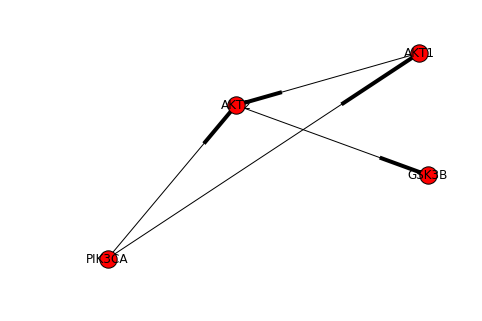

In [33]:
import networkx as nx
%matplotlib inline

v = nx.DiGraph()

valid_list = []
for statement in your_statements:
    if validate_bel_statement(statement, symbol2ec): #if statement is valid bel

        result = statement.split()
        #print(result)
        subj = get_bel_name(result[0])
        #print(subj)
        
        obj = get_bel_name(result[2])
        
        my_nodes = (subj,obj)
           
        valid_list.append(my_nodes)

        #print(valid_list)

v.add_edges_from(valid_list)

nx.draw(v, with_labels = True)

